In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [ ]:
import os
os.makedirs('models', exist_ok=True)

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [3]:
path = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet'

In [4]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    #df.head()
    df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    # filter
    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    
    df[categorical] = df[categorical].astype(str) #int -> str
    
    return df


In [5]:
df_train = read_dataframe(path)
df_val = read_dataframe(path)

In [7]:
#td = df.duration.iloc[0]
#td.total_seconds()
#df.duration.describe(percentiles=[0.95, 0.98, 0.99])
#numerical = ['trip_distance']
#df[categorical].dtypes
len(df_train) == len(df_val)

True

In [6]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [ ]:
#categorical = ['PULocationID', 'DOLocationID']
categorical = ['PU_DO']
numerical = ['trip_distance']

dv = DictVectorizer() #DictVectorizer는 딕셔너리 형태의 데이터를 머신러닝 모델이 사용할 수 있는 행렬(벡터)로 변환합니다.

#DataFrame에서 범주형(categorical)과 수치형(numerical) 컬럼만 선택해, 각 행을 딕셔너리로 변환합니다.
#결과는 딕셔너리의 리스트가 됩니다. (예: [{'col1': val1, 'col2': val2, ...}, ...])
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

#fit_transform은 학습과 변환을 동시에 수행합니다.
#X_train은 변환된 특성 행렬(2차원 배열, sparse matrix)입니다.
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

#예측하고자 하는 목표값(여기서는 'duration' 컬럼)을 y_train에 저장합니다.
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values



In [9]:
#선형회귀 모델을 생성하고, X_train(특성)과 y_train(목표값)으로 학습시킵니다.
lr = LinearRegression()
lr.fit(X_train, y_train)

#학습된 모델로 X_train에 대한 예측값을 구합니다.
y_pred = lr.predict(X_train)

#회귀 문제에서 예측값과 실제값의 차이를 제곱해 평균을 낸 값(MSE, 평균제곱오차)을 계산
mean_squared_error(y_train, y_pred, squared=False)

7.9460168727647265

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


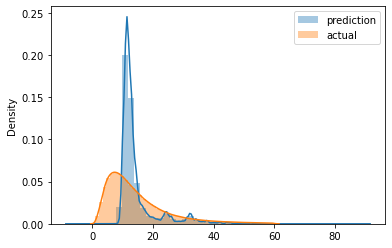

In [7]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [ ]:
lr = Lasso(alpha=0.001) 
#lr = Ridge(alpha=0.05)
lr.fit(X_train, y_train)

#학습된 모델로 X_train에 대한 예측값을 구합니다.
y_pred = lr.predict(X_train)

#회귀 문제에서 예측값과 실제값의 차이를 제곱해 평균을 낸 값(MSE, 평균제곱오차)을 계산
mean_squared_error(y_train, y_pred, squared=False)

In [ ]:
#'models/lin_reg.bin' 파일을 바이너리 쓰기 모드('wb')로 엽니다.
# pickle.dump((dv, lr), f_out)는 dv와 lr 객체를 튜플로 묶어 파일에 저장합니다.
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)    